# 1 Installation

In [1]:
import os
import sys
print(f"Python executable: {sys.executable}")

Python executable: /Users/martincastro/Downloads/img/venv/bin/python


In [2]:
import pandas as pd
print("Pandas version:", pd.__version__)

Pandas version: 2.0.3


In [3]:
import numpy as np

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset

In [5]:
import torchvision.transforms as transforms

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from transformers import ViTForImageClassification

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [8]:
from PIL import Image

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import random
from datetime import datetime, timedelta
import time

In [11]:
from typing import List, Tuple

In [12]:
from apparel import ApparelDataset, ApparelStackedDataset, ApparelProfiler

# 2 Settings

In [13]:
LABELS = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

In [14]:
WEIGHTS = {
    0: 1,
    1: 1,
    2: 1,
    3: 1,
    4: 2,  # Coas are also hard to classify.
    5: 1,
    6: 2,  # The largest amount of errors in the confusion matrix lie here.
    7: 1,
    8: 1,
    9: 1
}

In [15]:
MODEL_PATH = "models/v4.h5"

In [16]:
PREDICTIONS_PATH = "predictions/v4.csv"

In [17]:
BATCH_SIZE = 16  # Samples per batch to load during training.

In [18]:
IMAGE_SIZE = 224  # Balance between image detail and computational cost.

In [19]:
SAMPLE_COLUMNS = 5
SAMPLE_ROWS = 4

In [20]:
RANDOM_STATE = 53  # Seed for randomized functions.

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
# tf.random.set_seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [21]:
VALIDATION_SPLIT_RATIO = 0.2  # Ratio of validation datapoints.
TEST_SPLIT_RATIO = 0.5  # Ratio of test datapoints.

In [22]:
EPOCHS = 20  # Iterations during the training process.

In [23]:
PROCESSOR = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Processor:', PROCESSOR)

Processor: cpu


In [24]:
EARLY_STOPPING_PATIENCE = 3  # Number of epochs to wait for improvement before stopping

In [25]:
DROPOUT_RATE = 0.1  # Probability of dropping a weight during the training process.

In [26]:
LOADER_WORKERS = 4  # Amount of workers to use to load images.

In [27]:
AUGMENTED_RECORDS = 0.3  # Amount of records to include in data augmentation.

In [28]:
PRETRAINED_TRANSFORMER_NAME = 'google/vit-base-patch16-224'  # Too heavy but more powerful.
PRETRAINED_TRANSFORMER_NAME = 'facebook/deit-tiny-patch16-224'

In [29]:
STOP_AT_BATCH = None  # This is for debugging purposes. Should be set to None.

# 3 Data Loading

In this section, we define a custom dataset class `ApparelDataset` that extends the `Dataset` class from PyTorch. This custom dataset is designed to load images and their corresponding labels from a CSV file and a specified directory.

In [30]:
preprocessing = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

train_dataset = ApparelDataset.load(csv_path='data/train.csv', images_path='data/train', preprocessing=preprocessing)
print("Training dataset:", train_dataset, len(train_dataset), "records.")

Training dataset: <apparel.ApparelDataset object at 0x1627e4370> 60000 records.


# 4 Initial Exploratory Analysis

Performing an initial exploratory analysis of our dataset to understand its content. Additionally, plotting the distribution of labels to ensure the dataset is balanced.

In [31]:
print(train_dataset.df.dtypes)

id       int64
label    int64
dtype: object


In [32]:
def sample_dataset(dataset: Dataset) -> None:
    random_indices = random.sample(range(len(dataset)), SAMPLE_ROWS * SAMPLE_COLUMNS)
    random_images = [dataset[i][0] for i in random_indices]
    random_labels = [dataset[i][1] for i in random_indices]
    sample_images(random_images, random_labels)

In [33]:
def sample_images(images: List[np.array], labels: List[int]) -> None:
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        ax = plt.subplot(SAMPLE_ROWS, SAMPLE_COLUMNS, i + 1)  # Show 2 rows of 5 images.
        img = images[i].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        plt.imshow(img)
        plt.title(LABELS[labels[i].item()])  # The title of each image is the label.
        plt.axis("off")  # Hide the X and Y grid.
    plt.show()

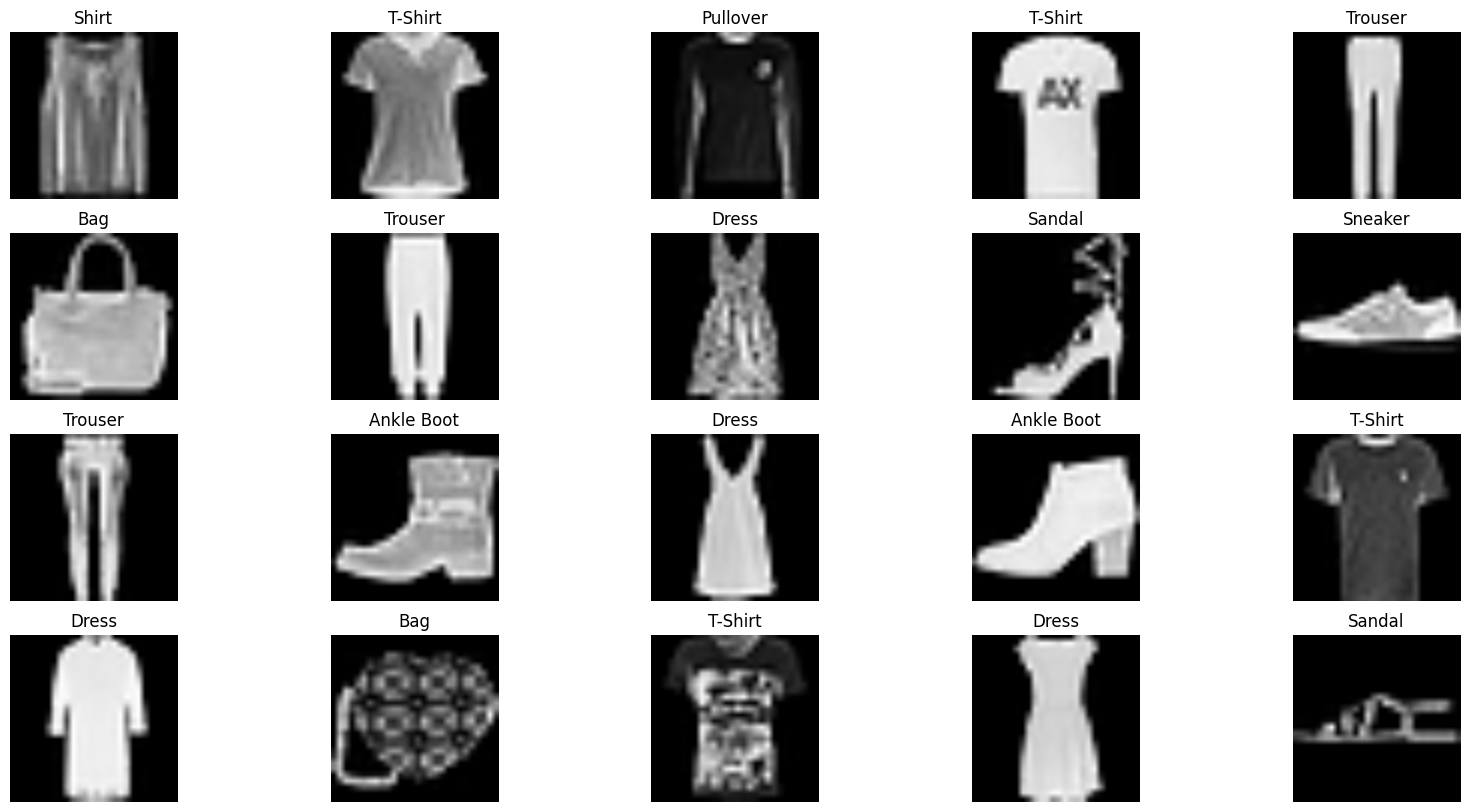

In [34]:
sample_dataset(train_dataset)

In [35]:
def plot_labels(dataset: Dataset) -> None:
    df = dataset.df
    df['label_names'] = df['label'].map(LABELS)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['label_names'], bins=len(df['label'].unique()), kde=False)
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.show()

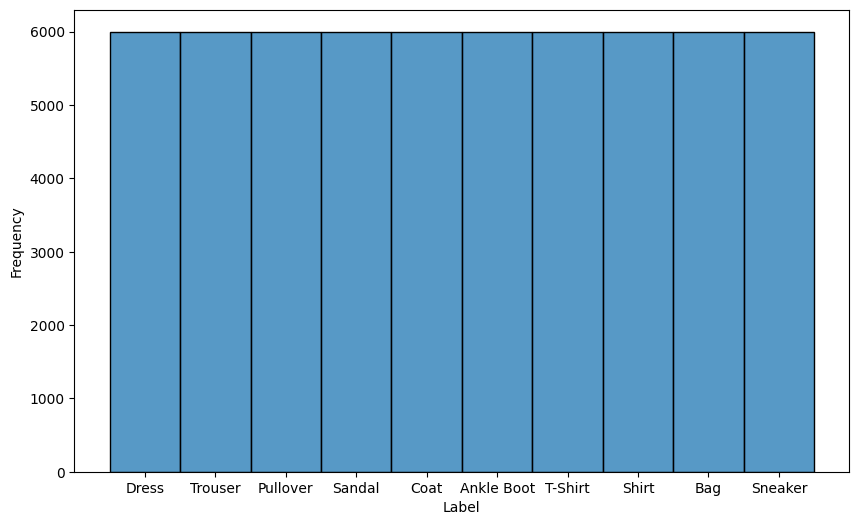

In [36]:
plot_labels(train_dataset)

# 5 Data Cleaning

Checking for null and duplicated values in the dataset. Fortunately, this dataset is already clean and balanced.

In [37]:
print("Null ids:", train_dataset.df.id.isnull().sum())

Null ids: 0


In [38]:
print("Null labels:", train_dataset.df.label.isnull().sum())

Null labels: 0


In [39]:
print("Duplicated rows:", train_dataset.df.duplicated().sum())

Duplicated rows: 0


# 6 Data Augmentation

Increasing the diversity of the training dataset to improve the robustness of our machine learning model. The augmented images are then combined with the original training dataset. This combined dataset is used to train the model.

In [40]:
augmentation = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.1),  # Horizontally flip the input with a given probability.
    transforms.RandomRotation(degrees=90),  # Rotate the input by angle.
    transforms.RandomPerspective(p=0.1),  # Perform a random perspective transformation of the input with a given probability.
    # transforms.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True),  # Crop a random portion of the input and resize it to a given size.
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmented_dataset = ApparelDataset.load(csv_path='data/train.csv', images_path='data/train', preprocessing=augmentation, sample=AUGMENTED_RECORDS)
print("Augmentation dataset:", augmented_dataset, len(augmented_dataset), "records")

Augmentation dataset: <apparel.ApparelDataset object at 0x163077a60> 6000 records


In [41]:
augmented_train_dataset = ApparelStackedDataset(train_dataset, augmented_dataset)
print("Augmented training dataset dataset:", augmented_train_dataset, len(augmented_train_dataset), "records")

assert len(augmented_train_dataset) == len(train_dataset) + len(augmented_dataset)
assert augmented_train_dataset[0][0].equal(train_dataset[0][0])
assert augmented_train_dataset[0][1] == train_dataset[0][1]
# assert augmented_train_dataset[len(train_dataset)][0].equal(augmented_dataset[0][0])  # Reading the image generates a random variant.
assert augmented_train_dataset[len(train_dataset)][1] == augmented_dataset[0][1]

Augmented training dataset dataset: <apparel.ApparelStackedDataset object at 0x1630aae50> 66000 records


# 7 Post-Cleaning Exploratory Analysis

Repeating the exploratory analysis to verify the effectiveness of the data cleaning and augmentation steps. This ensures the data augmentation step has not created weird things.

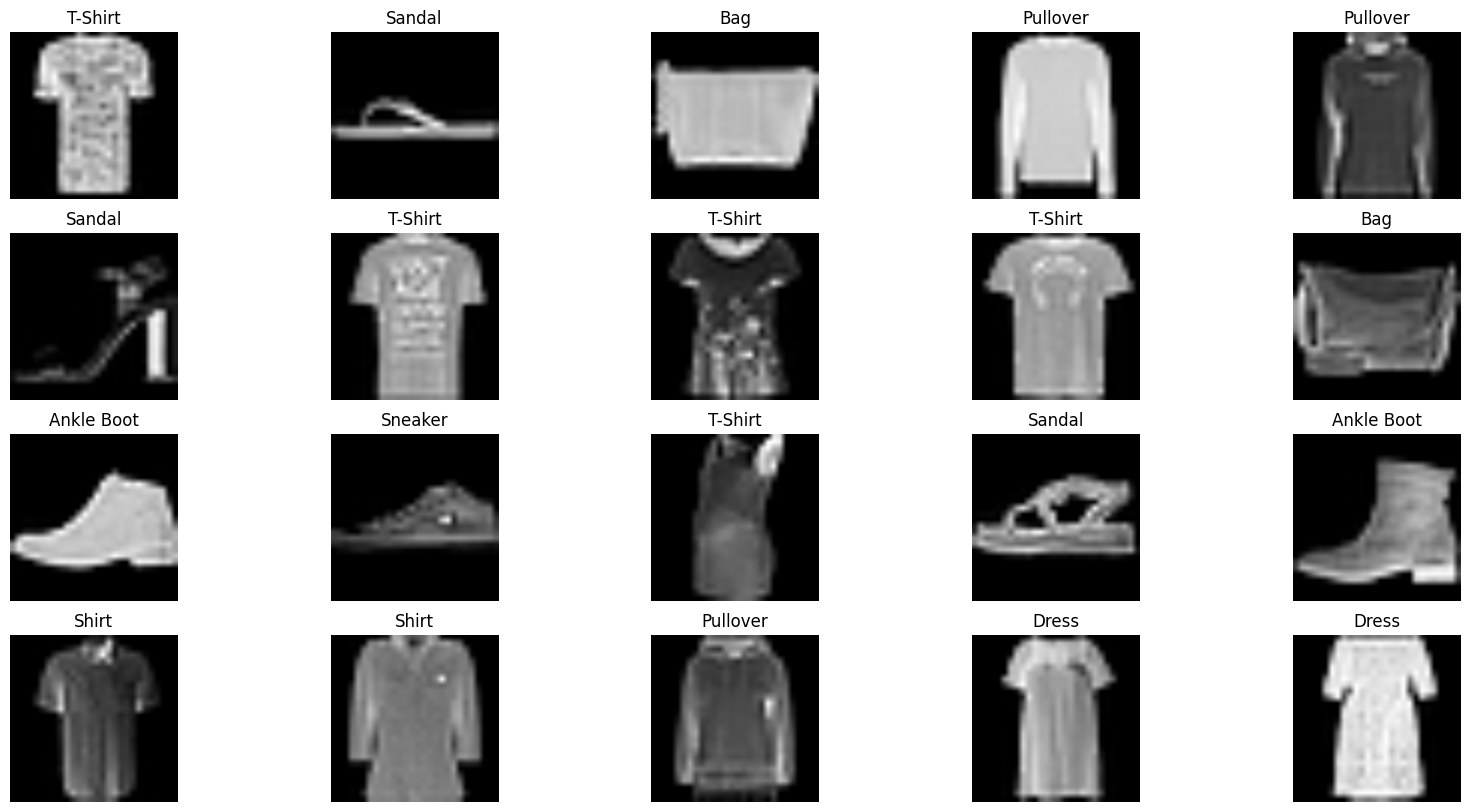

In [42]:
sample_dataset(augmented_train_dataset)

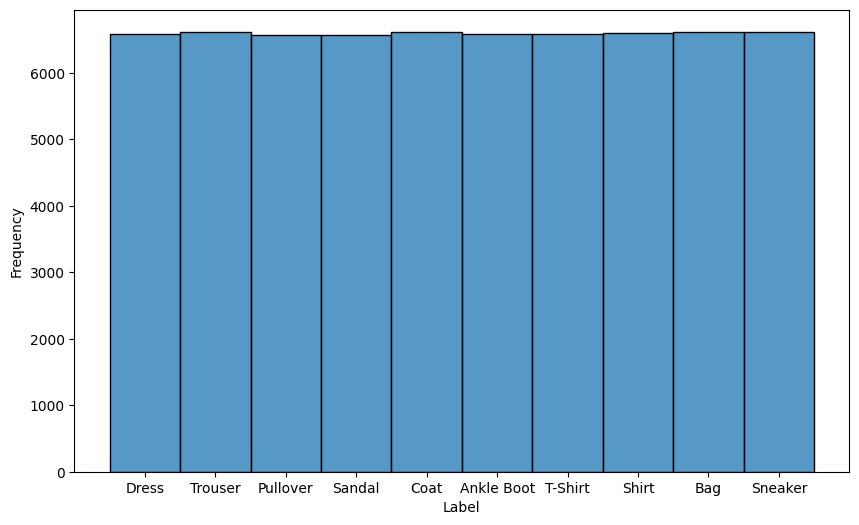

In [43]:
plot_labels(augmented_train_dataset)

# 8 Training and Validation Splitting

Splitting the augmented training dataset into training and validation sets using stratified sampling to maintain the same class distribution across both sets.

In [44]:
df = augmented_train_dataset.df
train_indices, val_test_indices = train_test_split(
    list(range(len(augmented_train_dataset))), 
    test_size=VALIDATION_SPLIT_RATIO, 
    stratify=df.label, 
    random_state=RANDOM_STATE
)
val_indices, test_indices = train_test_split(
    val_test_indices, 
    test_size=TEST_SPLIT_RATIO, 
    stratify=[df.label[i] for i in val_test_indices], 
    random_state=RANDOM_STATE
)
assert len(augmented_train_dataset) == len(train_indices) + len(test_indices) + len(val_indices)


print("Training indices:", train_indices[:10], "...")
print("Test indices:", test_indices[:10], "...")
print("Validation indices:", val_indices[:10], "...")

Training indices: [19830, 33745, 46030, 31844, 59742, 52355, 31652, 53646, 28280, 18203] ...
Test indices: [45425, 59041, 20335, 62195, 65221, 56026, 26403, 51798, 46371, 35746] ...
Validation indices: [13636, 51228, 25484, 40429, 20874, 55068, 37388, 9355, 3758, 27047] ...


In [45]:
train_subset = Subset(augmented_train_dataset, train_indices)
test_subset = Subset(augmented_train_dataset, test_indices)
val_subset = Subset(augmented_train_dataset, val_indices)
assert len(train_subset) + len(test_subset) + len(val_subset) == len(augmented_train_dataset)
print("Training dataset:", train_subset, len(train_subset), "records")
print("Test dataset:", test_subset, len(test_subset), "records")
print("Validation dataset:", val_subset, len(val_subset), "records")

Training dataset: <torch.utils.data.dataset.Subset object at 0x163784df0> 52800 records
Test dataset: <torch.utils.data.dataset.Subset object at 0x163784f70> 6600 records
Validation dataset: <torch.utils.data.dataset.Subset object at 0x1630aa520> 6600 records


In [46]:
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)

# 8 Model Preparation

Loading a pre-trained Vision Transformer model specifically designed for image classification with 10 labels using `ViTForImageClassification` from the Hugging Face, which is configured for a GPU (if available). Additionally, an Adam optimizer is set up with a learning rate of `1e-4` to adjust the model's parameters during training, and a cross-entropy loss function is defined to measure the performance of the model by comparing its predictions against the true labels.

In [47]:
class ApparelsModel(nn.Module):
    def __init__(self, base_model, num_labels):
        super(ApparelsModel, self).__init__()

        self.base_model = base_model
        # Freeze the base model
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        self.new_layers = nn.Sequential(
            nn.Linear(base_model.config.hidden_size, 1024),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),  # Adding dropout to reduce overfitting.
            nn.Linear(1024, 512),
            nn.BatchNorm1d(1024),
            nn.Dropout(DROPOUT_RATE),  # Adding dropout to reduce overfitting.
            nn.Linear(512, num_labels)
        )
        
    def forward(self, x):
        x = self.base_model.vit(x)  # Pass through the base ViT model
        x = x.last_hidden_state[:, 0]  # Get the output of the [CLS] token
        x = self.new_layers(x)  # Pass through the new layers
        return x

    def forward(self, x):
        # profiler = ApparelProfiler("Forward")
        # profiler.measure("BaseModel")
        x = self.base_model.vit(x)
        # profiler.measure("NewLayers")
        x = x.last_hidden_state[:, 0]
        x = self.new_layers(x)
        # profiler.stop()
        return x

In [48]:
base_model = ViTForImageClassification.from_pretrained(
    PRETRAINED_TRANSFORMER_NAME,
    ignore_mismatched_sizes=True,
    num_labels=len(LABELS)
)

model = ApparelsModel(base_model, num_labels=len(LABELS))
model = model.to(PROCESSOR)
print("Model:", model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: ApparelsModel(
  (base_model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=192, out_features=192, bias=True)
                (key): Linear(in_features=192, out_features=192, bias=True)
                (value): Linear(in_features=192, out_features=192, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=192, out_features=192, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
        

In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
class_weights = torch.tensor([
    WEIGHTS.get(i, 1)
    for i in range(len(LABELS))
], dtype=torch.float).to(PROCESSOR)
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)
print("Optimizer:", optimizer)
print("Loss function:", loss_function)

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Loss function: CrossEntropyLoss()


# 10 Model Training

Training the model, including forward and backward passes, validation, and early stopping.

In [50]:
def get_eta(start_time: float, current_batch: int, total_batches: int) -> datetime:
    elapsed_time = time.time() - start_time
    average_time_per_batch = elapsed_time / max(1, current_batch)
    pending_batches = total_batches - current_batch
    return datetime.now() + timedelta(seconds=average_time_per_batch * pending_batches)

In [51]:
def train_epoch(model: ApparelsModel) -> ApparelsModel:
    model.train()
    start_time = time.time()
    for batch_number, batch in enumerate(train_loader):
        print(datetime.now(), "Train - Batch:", batch_number, "of", len(train_loader), "ETA:", get_eta(start_time, batch_number, len(train_loader)))
        inputs, labels = batch[0].to(PROCESSOR), batch[1].to(PROCESSOR)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch_number == STOP_AT_BATCH: break
    return model

In [52]:
def evaluate_model(model: ApparelsModel, loader: DataLoader) -> Tuple[float, float, np.array]:
    loss = 0
    y_hat = []
    y_true = []
    model.eval() # Sets the model in evaluation model, which disables Dropout.
    start_time = time.time()
    with torch.no_grad():
        for batch_number, batch in enumerate(loader):
            print(datetime.now(), "Val - Batch:", batch_number, "of", len(loader), "ETA:", get_eta(start_time, batch_number, len(loader)))
            inputs, labels = batch[0].to(PROCESSOR), batch[1].to(PROCESSOR)
            outputs = model(inputs)
            batch_loss = loss_function(outputs, labels)
            loss += batch_loss.item()
            predictions = torch.argmax(outputs, dim=1)
            y_hat.extend(predictions.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            if batch_number == STOP_AT_BATCH: break
    loss /= len(loader)
    accuracy = accuracy_score(y_true, y_hat)
    conf_matrix = confusion_matrix(y_true, y_hat)
    return loss, accuracy, conf_matrix

In [53]:
def train(model: ApparelsModel, epochs: int, best_loss: float = float('inf')) -> Tuple[ApparelsModel, List[float]]:
    early_stop_counter = 0
    accuracies: List[float] = []
    for epoch in range(epochs):
        print(datetime.now(), "Epoch:", epoch)
        model = train_epoch(model)
        val_loss, val_accuracy, _ = evaluate_model(model, val_loader)
        accuracies.append(val_accuracy)
        print(datetime.now(), "Epoch:", epoch, "of", epochs, "Loss:", val_loss, "Accuracy:", val_accuracy),
        if val_loss < best_loss:
            best_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), MODEL_PATH)
            continue
        early_stop_counter += 1
        if early_stop_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping!")
            model.load_state_dict(torch.load(MODEL_PATH))
            break
    print(datetime.now(), "Training complete!")
    return model, accuracies

In [54]:
model, accuracies = train(model=model, epochs=EPOCHS)
print(f"Model Accuracy: {accuracies[-1]}")

2024-06-23 22:23:52.245092 Epoch: 0
2024-06-23 22:24:01.997463 Train - Batch: 0 of 3300 ETA: 2024-06-24 07:20:21.940866
2024-06-23 22:24:02.484971 Train - Batch: 1 of 3300 ETA: 2024-06-24 07:47:00.843223
2024-06-23 22:24:02.917479 Train - Batch: 2 of 3300 ETA: 2024-06-24 03:17:20.184775
2024-06-23 22:24:03.354278 Train - Batch: 3 of 3300 ETA: 2024-06-24 01:47:31.349499
2024-06-23 22:24:03.798145 Train - Batch: 4 of 3300 ETA: 2024-06-24 01:02:42.762896
2024-06-23 22:24:04.249793 Train - Batch: 5 of 3300 ETA: 2024-06-24 00:35:54.746570
2024-06-23 22:24:04.701617 Train - Batch: 6 of 3300 ETA: 2024-06-24 00:18:02.833640
2024-06-23 22:24:05.128565 Train - Batch: 7 of 3300 ETA: 2024-06-24 00:05:05.453784
2024-06-23 22:24:05.581828 Train - Batch: 8 of 3300 ETA: 2024-06-23 23:55:33.273721
2024-06-23 22:24:06.023712 Train - Batch: 9 of 3300 ETA: 2024-06-23 23:48:04.072920
2024-06-23 22:24:06.457817 Train - Batch: 10 of 3300 ETA: 2024-06-23 23:42:02.145954
2024-06-23 22:24:06.891693 Train - Batc

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:25:18.399696 Val - Batch: 0 of 413 ETA: 2024-06-23 23:37:28.074660
2024-06-23 22:25:18.862893 Val - Batch: 1 of 413 ETA: 2024-06-23 23:40:28.859245
2024-06-23 22:25:19.285663 Val - Batch: 2 of 413 ETA: 2024-06-23 23:04:15.690038
2024-06-23 22:25:19.704864 Val - Batch: 3 of 413 ETA: 2024-06-23 22:52:10.808689
2024-06-23 22:25:20.121813 Val - Batch: 4 of 413 ETA: 2024-06-23 22:46:08.135461
2024-06-23 22:25:20.536022 Val - Batch: 5 of 413 ETA: 2024-06-23 22:42:30.305306
2024-06-23 22:25:20.959247 Val - Batch: 6 of 413 ETA: 2024-06-23 22:40:05.705922
2024-06-23 22:25:21.370187 Val - Batch: 7 of 413 ETA: 2024-06-23 22:38:21.695649
2024-06-23 22:25:21.797979 Val - Batch: 8 of 413 ETA: 2024-06-23 22:37:04.557950
2024-06-23 22:25:22.218569 Val - Batch: 9 of 413 ETA: 2024-06-23 22:36:04.231615
2024-06-23 22:25:22.650892 Val - Batch: 10 of 413 ETA: 2024-06-23 22:35:16.454897
2024-06-23 22:25:23.085609 Val - Batch: 11 of 413 ETA: 2024-06-23 22:34:37.454889
2024-06-23 22:25:23.500597

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:26:22.177118 Epoch: 0 of 10 Loss: 0.23633754686350972 Accuracy: 0.7103960396039604
2024-06-23 22:26:22.274901 Epoch: 1
2024-06-23 22:26:32.605217 Train - Batch: 0 of 3300 ETA: 2024-06-24 07:54:39.255767
2024-06-23 22:26:33.097458 Train - Batch: 1 of 3300 ETA: 2024-06-24 08:21:32.958760
2024-06-23 22:26:33.532497 Train - Batch: 2 of 3300 ETA: 2024-06-24 03:35:55.430258
2024-06-23 22:26:33.977741 Train - Batch: 3 of 3300 ETA: 2024-06-24 02:00:54.147076
2024-06-23 22:26:34.416258 Train - Batch: 4 of 3300 ETA: 2024-06-24 01:13:17.955924
2024-06-23 22:26:34.850506 Train - Batch: 5 of 3300 ETA: 2024-06-24 00:44:41.423612
2024-06-23 22:26:35.281379 Train - Batch: 6 of 3300 ETA: 2024-06-24 00:25:35.212458
2024-06-23 22:26:35.737722 Train - Batch: 7 of 3300 ETA: 2024-06-24 00:12:08.498061
2024-06-23 22:26:36.178581 Train - Batch: 8 of 3300 ETA: 2024-06-24 00:01:57.074188
2024-06-23 22:26:36.609944 Train - Batch: 9 of 3300 ETA: 2024-06-23 23:53:58.040432
2024-06-23 22:26:37.039498 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:27:47.474631 Val - Batch: 0 of 413 ETA: 2024-06-23 23:42:15.620477
2024-06-23 22:27:47.955866 Val - Batch: 1 of 413 ETA: 2024-06-23 23:45:23.531110
2024-06-23 22:27:48.374903 Val - Batch: 2 of 413 ETA: 2024-06-23 23:07:56.624688
2024-06-23 22:27:48.791732 Val - Batch: 3 of 413 ETA: 2024-06-23 22:55:27.352045
2024-06-23 22:27:49.220292 Val - Batch: 4 of 413 ETA: 2024-06-23 22:49:13.926841
2024-06-23 22:27:49.643495 Val - Batch: 5 of 413 ETA: 2024-06-23 22:45:29.429229
2024-06-23 22:27:50.061664 Val - Batch: 6 of 413 ETA: 2024-06-23 22:42:59.417649
2024-06-23 22:27:50.478128 Val - Batch: 7 of 413 ETA: 2024-06-23 22:41:12.165986
2024-06-23 22:27:50.889664 Val - Batch: 8 of 413 ETA: 2024-06-23 22:39:51.472714
2024-06-23 22:27:51.312603 Val - Batch: 9 of 413 ETA: 2024-06-23 22:38:49.234608
2024-06-23 22:27:51.727740 Val - Batch: 10 of 413 ETA: 2024-06-23 22:37:59.121864
2024-06-23 22:27:52.145411 Val - Batch: 11 of 413 ETA: 2024-06-23 22:37:18.215654
2024-06-23 22:27:52.564828

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:28:50.364078 Epoch: 1 of 10 Loss: 0.18705171310584134 Accuracy: 0.7716584158415841
2024-06-23 22:28:50.461735 Epoch: 2
2024-06-23 22:29:00.896449 Train - Batch: 0 of 3300 ETA: 2024-06-24 08:02:51.740160
2024-06-23 22:29:01.387538 Train - Batch: 1 of 3300 ETA: 2024-06-24 08:29:41.732248
2024-06-23 22:29:01.824186 Train - Batch: 2 of 3300 ETA: 2024-06-24 03:41:16.565038
2024-06-23 22:29:02.267164 Train - Batch: 3 of 3300 ETA: 2024-06-24 02:05:15.140292
2024-06-23 22:29:02.704671 Train - Batch: 4 of 3300 ETA: 2024-06-24 01:17:09.913369
2024-06-23 22:29:03.135120 Train - Batch: 5 of 3300 ETA: 2024-06-24 00:48:14.120887
2024-06-23 22:29:03.582132 Train - Batch: 6 of 3300 ETA: 2024-06-24 00:29:06.033417
2024-06-23 22:29:04.043179 Train - Batch: 7 of 3300 ETA: 2024-06-24 00:15:32.589679
2024-06-23 22:29:04.485906 Train - Batch: 8 of 3300 ETA: 2024-06-24 00:05:14.947973
2024-06-23 22:29:04.918971 Train - Batch: 9 of 3300 ETA: 2024-06-23 23:57:11.017540
2024-06-23 22:29:05.347394 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:30:17.034381 Val - Batch: 0 of 413 ETA: 2024-06-23 23:54:07.254662
2024-06-23 22:30:17.586769 Val - Batch: 1 of 413 ETA: 2024-06-23 23:57:43.184000
2024-06-23 22:30:18.042437 Val - Batch: 2 of 413 ETA: 2024-06-23 23:15:28.114569
2024-06-23 22:30:18.496161 Val - Batch: 3 of 413 ETA: 2024-06-23 23:01:22.823694
2024-06-23 22:30:18.956313 Val - Batch: 4 of 413 ETA: 2024-06-23 22:54:20.842145
2024-06-23 22:30:19.416231 Val - Batch: 5 of 413 ETA: 2024-06-23 22:50:07.634073
2024-06-23 22:30:19.889171 Val - Batch: 6 of 413 ETA: 2024-06-23 22:47:19.724824
2024-06-23 22:30:20.354257 Val - Batch: 7 of 413 ETA: 2024-06-23 22:45:19.326315
2024-06-23 22:30:20.816269 Val - Batch: 8 of 413 ETA: 2024-06-23 22:43:48.868793
2024-06-23 22:30:21.286769 Val - Batch: 9 of 413 ETA: 2024-06-23 22:42:38.902356
2024-06-23 22:30:21.798122 Val - Batch: 10 of 413 ETA: 2024-06-23 22:41:44.616465
2024-06-23 22:30:22.292917 Val - Batch: 11 of 413 ETA: 2024-06-23 22:40:59.579187
2024-06-23 22:30:22.851340

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:31:23.397763 Epoch: 2 of 10 Loss: 0.16808530937239852 Accuracy: 0.7896039603960396
2024-06-23 22:31:23.448830 Epoch: 3
2024-06-23 22:31:35.216721 Train - Batch: 0 of 3300 ETA: 2024-06-24 09:18:45.604674
2024-06-23 22:31:35.870240 Train - Batch: 1 of 3300 ETA: 2024-06-24 09:54:30.134023
2024-06-23 22:31:36.370024 Train - Batch: 2 of 3300 ETA: 2024-06-24 04:26:41.460412
2024-06-23 22:31:36.912315 Train - Batch: 3 of 3300 ETA: 2024-06-24 02:38:11.957310
2024-06-23 22:31:37.420912 Train - Batch: 4 of 3300 ETA: 2024-06-24 01:43:29.422937
2024-06-23 22:31:37.916327 Train - Batch: 5 of 3300 ETA: 2024-06-24 01:10:31.202086
2024-06-23 22:31:38.401627 Train - Batch: 6 of 3300 ETA: 2024-06-24 00:48:26.829050
2024-06-23 22:31:38.882122 Train - Batch: 7 of 3300 ETA: 2024-06-24 00:32:38.575411
2024-06-23 22:31:39.354064 Train - Batch: 8 of 3300 ETA: 2024-06-24 00:20:43.860894
2024-06-23 22:31:39.841542 Train - Batch: 9 of 3300 ETA: 2024-06-24 00:11:33.668646
2024-06-23 22:31:40.324685 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:32:54.457793 Val - Batch: 0 of 413 ETA: 2024-06-23 23:46:12.489039
2024-06-23 22:32:54.918592 Val - Batch: 1 of 413 ETA: 2024-06-23 23:49:12.122755
2024-06-23 22:32:55.336867 Val - Batch: 2 of 413 ETA: 2024-06-23 23:12:24.339389
2024-06-23 22:32:55.741760 Val - Batch: 3 of 413 ETA: 2024-06-23 23:00:06.569645
2024-06-23 22:32:56.156113 Val - Batch: 4 of 413 ETA: 2024-06-23 22:53:58.661418
2024-06-23 22:32:56.575029 Val - Batch: 5 of 413 ETA: 2024-06-23 22:50:18.293294
2024-06-23 22:32:56.998376 Val - Batch: 6 of 413 ETA: 2024-06-23 22:47:51.686197
2024-06-23 22:32:57.409375 Val - Batch: 7 of 413 ETA: 2024-06-23 22:46:06.238440
2024-06-23 22:32:57.824080 Val - Batch: 8 of 413 ETA: 2024-06-23 22:44:47.343942
2024-06-23 22:32:58.236115 Val - Batch: 9 of 413 ETA: 2024-06-23 22:43:45.858944
2024-06-23 22:32:58.664095 Val - Batch: 10 of 413 ETA: 2024-06-23 22:42:57.329559
2024-06-23 22:32:59.096245 Val - Batch: 11 of 413 ETA: 2024-06-23 22:42:17.780181
2024-06-23 22:32:59.511420

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:34:00.458073 Epoch: 3 of 10 Loss: 0.16556000240489877 Accuracy: 0.8025990099009901
2024-06-23 22:34:00.509673 Epoch: 4
2024-06-23 22:34:12.720107 Train - Batch: 0 of 3300 ETA: 2024-06-24 09:45:43.446573
2024-06-23 22:34:13.196250 Train - Batch: 1 of 3300 ETA: 2024-06-24 10:11:42.123253
2024-06-23 22:34:13.642081 Train - Batch: 2 of 3300 ETA: 2024-06-24 04:35:06.937949
2024-06-23 22:34:14.125615 Train - Batch: 3 of 3300 ETA: 2024-06-24 02:43:36.683118
2024-06-23 22:34:14.630710 Train - Batch: 4 of 3300 ETA: 2024-06-24 01:48:09.342468
2024-06-23 22:34:15.168676 Train - Batch: 5 of 3300 ETA: 2024-06-24 01:15:14.635932
2024-06-23 22:34:15.673689 Train - Batch: 6 of 3300 ETA: 2024-06-24 00:53:00.037729
2024-06-23 22:34:16.124945 Train - Batch: 7 of 3300 ETA: 2024-06-24 00:36:41.411298
2024-06-23 22:34:16.655673 Train - Batch: 8 of 3300 ETA: 2024-06-24 00:25:00.224389
2024-06-23 22:34:17.166786 Train - Batch: 9 of 3300 ETA: 2024-06-24 00:15:47.664389
2024-06-23 22:34:17.633952 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:35:35.127517 Val - Batch: 0 of 413 ETA: 2024-06-24 00:06:00.389403
2024-06-23 22:35:35.747958 Val - Batch: 1 of 413 ETA: 2024-06-24 00:10:03.471759
2024-06-23 22:35:36.224232 Val - Batch: 2 of 413 ETA: 2024-06-23 23:24:21.081557
2024-06-23 22:35:36.714728 Val - Batch: 3 of 413 ETA: 2024-06-23 23:09:08.909897
2024-06-23 22:35:37.199637 Val - Batch: 4 of 413 ETA: 2024-06-23 23:01:32.247323
2024-06-23 22:35:37.684605 Val - Batch: 5 of 413 ETA: 2024-06-23 22:56:58.254328
2024-06-23 22:35:38.166504 Val - Batch: 6 of 413 ETA: 2024-06-23 22:53:55.381085
2024-06-23 22:35:38.648408 Val - Batch: 7 of 413 ETA: 2024-06-23 22:51:44.757918
2024-06-23 22:35:39.140186 Val - Batch: 8 of 413 ETA: 2024-06-23 22:50:07.299987
2024-06-23 22:35:39.663688 Val - Batch: 9 of 413 ETA: 2024-06-23 22:48:52.955369
2024-06-23 22:35:40.147546 Val - Batch: 10 of 413 ETA: 2024-06-23 22:47:51.842270
2024-06-23 22:35:40.628238 Val - Batch: 11 of 413 ETA: 2024-06-23 22:47:01.721811
2024-06-23 22:35:41.104227

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:36:50.641248 Epoch: 4 of 10 Loss: 0.163943117813683 Accuracy: 0.8038366336633663
2024-06-23 22:36:50.694619 Epoch: 5
2024-06-23 22:37:01.816415 Train - Batch: 0 of 3300 ETA: 2024-06-24 08:48:40.195394
2024-06-23 22:37:02.290396 Train - Batch: 1 of 3300 ETA: 2024-06-24 09:14:32.849734
2024-06-23 22:37:02.719650 Train - Batch: 2 of 3300 ETA: 2024-06-24 04:07:30.041575
2024-06-23 22:37:03.145585 Train - Batch: 3 of 3300 ETA: 2024-06-24 02:25:05.454858
2024-06-23 22:37:03.568184 Train - Batch: 4 of 3300 ETA: 2024-06-24 01:33:50.408354
2024-06-23 22:37:03.987948 Train - Batch: 5 of 3300 ETA: 2024-06-24 01:03:03.510116
2024-06-23 22:37:04.419140 Train - Batch: 6 of 3300 ETA: 2024-06-24 00:42:38.551463
2024-06-23 22:37:04.846060 Train - Batch: 7 of 3300 ETA: 2024-06-24 00:28:01.530756
2024-06-23 22:37:05.325450 Train - Batch: 8 of 3300 ETA: 2024-06-24 00:17:25.425119
2024-06-23 22:37:05.813074 Train - Batch: 9 of 3300 ETA: 2024-06-24 00:09:13.694820
2024-06-23 22:37:06.285131 Tr

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:38:25.013461 Val - Batch: 0 of 413 ETA: 2024-06-24 00:03:17.823636
2024-06-23 22:38:25.532206 Val - Batch: 1 of 413 ETA: 2024-06-24 00:06:39.659299
2024-06-23 22:38:26.009821 Val - Batch: 2 of 413 ETA: 2024-06-23 23:24:04.798963
2024-06-23 22:38:26.472929 Val - Batch: 3 of 413 ETA: 2024-06-23 23:09:51.181155
2024-06-23 22:38:26.925957 Val - Batch: 4 of 413 ETA: 2024-06-23 23:02:43.331530
2024-06-23 22:38:27.386274 Val - Batch: 5 of 413 ETA: 2024-06-23 22:58:27.223880
2024-06-23 22:38:27.827056 Val - Batch: 6 of 413 ETA: 2024-06-23 22:55:35.140799
2024-06-23 22:38:28.298961 Val - Batch: 7 of 413 ETA: 2024-06-23 22:53:34.060622
2024-06-23 22:38:28.770772 Val - Batch: 8 of 413 ETA: 2024-06-23 22:52:03.245540
2024-06-23 22:38:29.213867 Val - Batch: 9 of 413 ETA: 2024-06-23 22:50:51.293795
2024-06-23 22:38:29.676792 Val - Batch: 10 of 413 ETA: 2024-06-23 22:49:54.551614
2024-06-23 22:38:30.166238 Val - Batch: 11 of 413 ETA: 2024-06-23 22:49:09.121792
2024-06-23 22:38:30.636696

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:39:37.463169 Epoch: 5 of 10 Loss: 0.15938452301100436 Accuracy: 0.8025990099009901
2024-06-23 22:39:37.513840 Epoch: 6
2024-06-23 22:39:48.407939 Train - Batch: 0 of 3300 ETA: 2024-06-24 08:38:54.842661
2024-06-23 22:39:48.892837 Train - Batch: 1 of 3300 ETA: 2024-06-24 09:05:23.985254
2024-06-23 22:39:49.412987 Train - Batch: 2 of 3300 ETA: 2024-06-24 04:06:48.963000
2024-06-23 22:39:49.891065 Train - Batch: 3 of 3300 ETA: 2024-06-24 02:26:31.032730
2024-06-23 22:39:50.356385 Train - Batch: 4 of 3300 ETA: 2024-06-24 01:36:11.541445
2024-06-23 22:39:50.817706 Train - Batch: 5 of 3300 ETA: 2024-06-24 01:05:57.207967
2024-06-23 22:39:51.269496 Train - Batch: 6 of 3300 ETA: 2024-06-24 00:45:42.409860
2024-06-23 22:39:51.720673 Train - Batch: 7 of 3300 ETA: 2024-06-24 00:31:14.409302
2024-06-23 22:39:52.184646 Train - Batch: 8 of 3300 ETA: 2024-06-24 00:20:28.686415
2024-06-23 22:39:52.681728 Train - Batch: 9 of 3300 ETA: 2024-06-24 00:12:18.597800
2024-06-23 22:39:53.188054 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:41:06.855417 Val - Batch: 0 of 413 ETA: 2024-06-23 23:54:32.249244
2024-06-23 22:41:07.346457 Val - Batch: 1 of 413 ETA: 2024-06-23 23:57:44.348567
2024-06-23 22:41:07.796323 Val - Batch: 2 of 413 ETA: 2024-06-23 23:20:53.165976
2024-06-23 22:41:08.319325 Val - Batch: 3 of 413 ETA: 2024-06-23 23:08:46.173645
2024-06-23 22:41:08.837436 Val - Batch: 4 of 413 ETA: 2024-06-23 23:02:42.172468
2024-06-23 22:41:09.337924 Val - Batch: 5 of 413 ETA: 2024-06-23 22:59:02.315949
2024-06-23 22:41:09.801099 Val - Batch: 6 of 413 ETA: 2024-06-23 22:56:33.177364
2024-06-23 22:41:10.314906 Val - Batch: 7 of 413 ETA: 2024-06-23 22:54:49.635866
2024-06-23 22:41:10.783482 Val - Batch: 8 of 413 ETA: 2024-06-23 22:53:29.645155
2024-06-23 22:41:11.245349 Val - Batch: 9 of 413 ETA: 2024-06-23 22:52:27.122339
2024-06-23 22:41:11.701221 Val - Batch: 10 of 413 ETA: 2024-06-23 22:51:36.856443
2024-06-23 22:41:12.167921 Val - Batch: 11 of 413 ETA: 2024-06-23 22:50:56.136432
2024-06-23 22:41:12.618061

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:42:13.235377 Epoch: 6 of 10 Loss: 0.1582286030631377 Accuracy: 0.8106435643564357
2024-06-23 22:42:13.287872 Epoch: 7
2024-06-23 22:42:25.433158 Train - Batch: 0 of 3300 ETA: 2024-06-24 09:50:20.619294
2024-06-23 22:42:25.900706 Train - Batch: 1 of 3300 ETA: 2024-06-24 10:15:51.044244
2024-06-23 22:42:26.330174 Train - Batch: 2 of 3300 ETA: 2024-06-24 04:40:50.787645
2024-06-23 22:42:26.856877 Train - Batch: 3 of 3300 ETA: 2024-06-24 02:50:57.663459
2024-06-23 22:42:27.341222 Train - Batch: 4 of 3300 ETA: 2024-06-24 01:55:26.154702
2024-06-23 22:42:27.845026 Train - Batch: 5 of 3300 ETA: 2024-06-24 01:22:20.092082
2024-06-23 22:42:28.343252 Train - Batch: 6 of 3300 ETA: 2024-06-24 01:00:12.982542
2024-06-23 22:42:28.830919 Train - Batch: 7 of 3300 ETA: 2024-06-24 00:44:20.069977
2024-06-23 22:42:29.332879 Train - Batch: 8 of 3300 ETA: 2024-06-24 00:32:31.280416
2024-06-23 22:42:29.807687 Train - Batch: 9 of 3300 ETA: 2024-06-24 00:23:10.044413
2024-06-23 22:42:30.266431 T

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:43:45.375605 Val - Batch: 0 of 413 ETA: 2024-06-24 00:04:48.360165
2024-06-23 22:43:45.881232 Val - Batch: 1 of 413 ETA: 2024-06-24 00:08:05.372177
2024-06-23 22:43:46.353027 Val - Batch: 2 of 413 ETA: 2024-06-23 23:27:26.912437
2024-06-23 22:43:46.801897 Val - Batch: 3 of 413 ETA: 2024-06-23 23:13:50.936101
2024-06-23 22:43:47.286681 Val - Batch: 4 of 413 ETA: 2024-06-23 23:07:06.656369
2024-06-23 22:43:47.744052 Val - Batch: 5 of 413 ETA: 2024-06-23 23:03:01.824126
2024-06-23 22:43:48.204586 Val - Batch: 6 of 413 ETA: 2024-06-23 23:00:18.820407
2024-06-23 22:43:48.695204 Val - Batch: 7 of 413 ETA: 2024-06-23 22:58:24.164030
2024-06-23 22:43:49.158913 Val - Batch: 8 of 413 ETA: 2024-06-23 22:56:56.782615
2024-06-23 22:43:49.626178 Val - Batch: 9 of 413 ETA: 2024-06-23 22:55:48.982438
2024-06-23 22:43:50.083285 Val - Batch: 10 of 413 ETA: 2024-06-23 22:54:54.322771
2024-06-23 22:43:50.543283 Val - Batch: 11 of 413 ETA: 2024-06-23 22:54:09.709878
2024-06-23 22:43:50.994964

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:44:53.037914 Epoch: 7 of 10 Loss: 0.15357100012876798 Accuracy: 0.8137376237623762
2024-06-23 22:44:53.114485 Epoch: 8
2024-06-23 22:45:04.576934 Train - Batch: 0 of 3300 ETA: 2024-06-24 09:15:27.220033
2024-06-23 22:45:05.076959 Train - Batch: 1 of 3300 ETA: 2024-06-24 09:42:45.336122
2024-06-23 22:45:05.610161 Train - Batch: 2 of 3300 ETA: 2024-06-24 04:28:29.007920
2024-06-23 22:45:06.093182 Train - Batch: 3 of 3300 ETA: 2024-06-24 02:42:48.366708
2024-06-23 22:45:06.593500 Train - Batch: 4 of 3300 ETA: 2024-06-24 01:50:12.315561
2024-06-23 22:45:07.056201 Train - Batch: 5 of 3300 ETA: 2024-06-24 01:18:13.858303
2024-06-23 22:45:07.523072 Train - Batch: 6 of 3300 ETA: 2024-06-24 00:56:57.180135
2024-06-23 22:45:07.977365 Train - Batch: 7 of 3300 ETA: 2024-06-24 00:41:39.338534
2024-06-23 22:45:08.455757 Train - Batch: 8 of 3300 ETA: 2024-06-24 00:30:20.896154
2024-06-23 22:45:08.922651 Train - Batch: 9 of 3300 ETA: 2024-06-24 00:21:29.005093
2024-06-23 22:45:09.428554 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:46:25.153738 Val - Batch: 0 of 413 ETA: 2024-06-24 00:11:03.802152
2024-06-23 22:46:25.625759 Val - Batch: 1 of 413 ETA: 2024-06-24 00:14:06.397415
2024-06-23 22:46:26.071547 Val - Batch: 2 of 413 ETA: 2024-06-23 23:31:41.683205
2024-06-23 22:46:26.533771 Val - Batch: 3 of 413 ETA: 2024-06-23 23:17:35.706590
2024-06-23 22:46:27.005200 Val - Batch: 4 of 413 ETA: 2024-06-23 23:10:33.669620
2024-06-23 22:46:27.479681 Val - Batch: 5 of 413 ETA: 2024-06-23 23:06:20.699121
2024-06-23 22:46:27.946133 Val - Batch: 6 of 413 ETA: 2024-06-23 23:03:31.499458
2024-06-23 22:46:28.405224 Val - Batch: 7 of 413 ETA: 2024-06-23 23:01:30.208332
2024-06-23 22:46:28.867842 Val - Batch: 8 of 413 ETA: 2024-06-23 22:59:59.421954
2024-06-23 22:46:29.322501 Val - Batch: 9 of 413 ETA: 2024-06-23 22:58:48.445332
2024-06-23 22:46:29.783312 Val - Batch: 10 of 413 ETA: 2024-06-23 22:57:51.917941
2024-06-23 22:46:30.248026 Val - Batch: 11 of 413 ETA: 2024-06-23 22:57:05.814838
2024-06-23 22:46:30.714946

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:47:30.707569 Epoch: 8 of 10 Loss: 0.15060313399565423 Accuracy: 0.8186881188118812
2024-06-23 22:47:30.757388 Epoch: 9
2024-06-23 22:47:41.810327 Train - Batch: 0 of 3300 ETA: 2024-06-24 08:55:32.819800
2024-06-23 22:47:42.310253 Train - Batch: 1 of 3300 ETA: 2024-06-24 09:22:50.959951
2024-06-23 22:47:42.744598 Train - Batch: 2 of 3300 ETA: 2024-06-24 04:17:07.526618
2024-06-23 22:47:43.187403 Train - Batch: 3 of 3300 ETA: 2024-06-24 02:35:22.358562
2024-06-23 22:47:43.651413 Train - Batch: 4 of 3300 ETA: 2024-06-24 01:44:47.264485
2024-06-23 22:47:44.126664 Train - Batch: 5 of 3300 ETA: 2024-06-24 01:14:33.630219
2024-06-23 22:47:44.673596 Train - Batch: 6 of 3300 ETA: 2024-06-24 00:55:03.964879
2024-06-23 22:47:45.211309 Train - Batch: 7 of 3300 ETA: 2024-06-24 00:41:04.144804
2024-06-23 22:47:45.725699 Train - Batch: 8 of 3300 ETA: 2024-06-24 00:30:24.655345
2024-06-23 22:47:46.192479 Train - Batch: 9 of 3300 ETA: 2024-06-24 00:21:49.819476
2024-06-23 22:47:46.660447 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:49:02.285448 Val - Batch: 0 of 413 ETA: 2024-06-24 00:16:33.398053
2024-06-23 22:49:02.848563 Val - Batch: 1 of 413 ETA: 2024-06-24 00:20:13.216561
2024-06-23 22:49:03.322786 Val - Batch: 2 of 413 ETA: 2024-06-23 23:36:09.320361
2024-06-23 22:49:03.778715 Val - Batch: 3 of 413 ETA: 2024-06-23 23:21:25.503895
2024-06-23 22:49:04.332414 Val - Batch: 4 of 413 ETA: 2024-06-23 23:14:13.690191
2024-06-23 22:49:04.816785 Val - Batch: 5 of 413 ETA: 2024-06-23 23:09:48.875156
2024-06-23 22:49:05.302399 Val - Batch: 6 of 413 ETA: 2024-06-23 23:06:52.417759
2024-06-23 22:49:05.791248 Val - Batch: 7 of 413 ETA: 2024-06-23 23:04:46.567393
2024-06-23 22:49:06.256814 Val - Batch: 8 of 413 ETA: 2024-06-23 23:03:10.977685
2024-06-23 22:49:06.699527 Val - Batch: 9 of 413 ETA: 2024-06-23 23:01:55.581350
2024-06-23 22:49:07.113486 Val - Batch: 10 of 413 ETA: 2024-06-23 23:00:54.076822
2024-06-23 22:49:07.550716 Val - Batch: 11 of 413 ETA: 2024-06-23 23:00:04.628613
2024-06-23 22:49:07.966921

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:50:08.832400 Epoch: 9 of 10 Loss: 0.1514042178416945 Accuracy: 0.8199257425742574
2024-06-23 22:50:08.832594 Training complete!
Model Accuracy: 0.8199257425742574


# 11 Model Evaluation

Eavluating the model's performance on the test set by calculating the test loss, accuracy, and confusion matrix.

In [55]:
test_loss, test_accuracy, conf_matrix = evaluate_model(model, test_loader)

2024-06-23 22:50:21.895017 Val - Batch: 0 of 413 ETA: 2024-06-24 00:20:10.599710
2024-06-23 22:50:22.353246 Val - Batch: 1 of 413 ETA: 2024-06-24 00:23:06.770471
2024-06-23 22:50:22.762883 Val - Batch: 2 of 413 ETA: 2024-06-23 23:38:02.398527
2024-06-23 22:50:23.175128 Val - Batch: 3 of 413 ETA: 2024-06-23 23:23:01.300681
2024-06-23 22:50:23.590179 Val - Batch: 4 of 413 ETA: 2024-06-23 23:15:31.041374
2024-06-23 22:50:24.014462 Val - Batch: 5 of 413 ETA: 2024-06-23 23:11:01.648279
2024-06-23 22:50:24.434282 Val - Batch: 6 of 413 ETA: 2024-06-23 23:08:01.745747
2024-06-23 22:50:24.846073 Val - Batch: 7 of 413 ETA: 2024-06-23 23:05:52.770214
2024-06-23 22:50:25.499787 Val - Batch: 8 of 413 ETA: 2024-06-23 23:04:28.528164
2024-06-23 22:50:26.040623 Val - Batch: 9 of 413 ETA: 2024-06-23 23:03:17.826162
2024-06-23 22:50:26.527178 Val - Batch: 10 of 413 ETA: 2024-06-23 23:02:19.023880
2024-06-23 22:50:26.958244 Val - Batch: 11 of 413 ETA: 2024-06-23 23:01:28.827972
2024-06-23 22:50:27.366291

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

In [56]:
print("Test Loss:", test_loss)
print("Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)

Test Loss: 0.15328332731279276
Accuracy: 0.7933168316831684
Confusion Matrix:
 [[ 91   0  17   7   6   0  26   0   5   0]
 [  0 164   1   7   0   1   1   0   1   0]
 [  3   0 131   5  17   0  21   0   2   0]
 [  7   1   7 132  10   1  11   0   0   0]
 [  0   0  17   9 118   0  22   0   1   0]
 [  0   0   0   1   0 144   0  11   1   1]
 [ 11   0  15  10  26   0 101   0   2   0]
 [  0   0   0   1   0  11   1 130   0   5]
 [  2   0   1   1   1   2   1   1 138   0]
 [  0   0   1   0   2   3   0  17   0 133]]


# 12 Performance Tuning

Visualizing the validation loss and test loss over epochs and the confusion matrix. This step help update the settings of the model to improve the results. Additionally, there are multiple versions of this model, so at the end of the day, we only keep the best one.

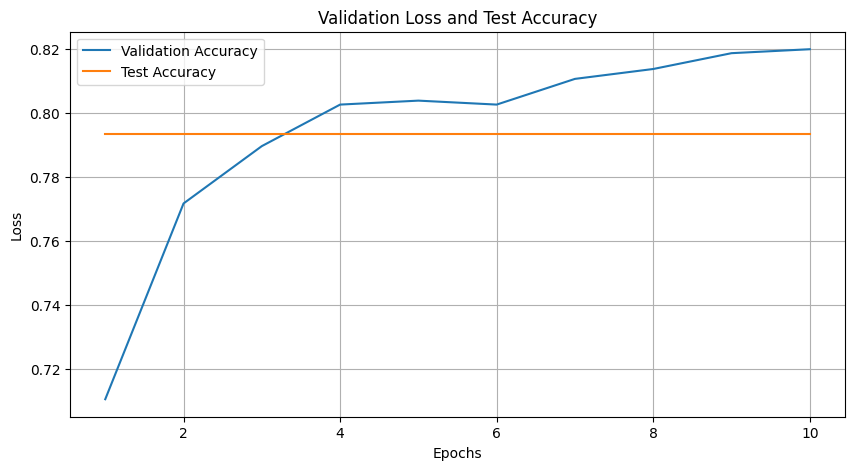

In [57]:
assert len(accuracies) > 0
assert test_accuracy > 0
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Validation Accuracy')
plt.plot(range(1, len(accuracies) + 1), [test_accuracy for _ in range(len(accuracies))], label="Test Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

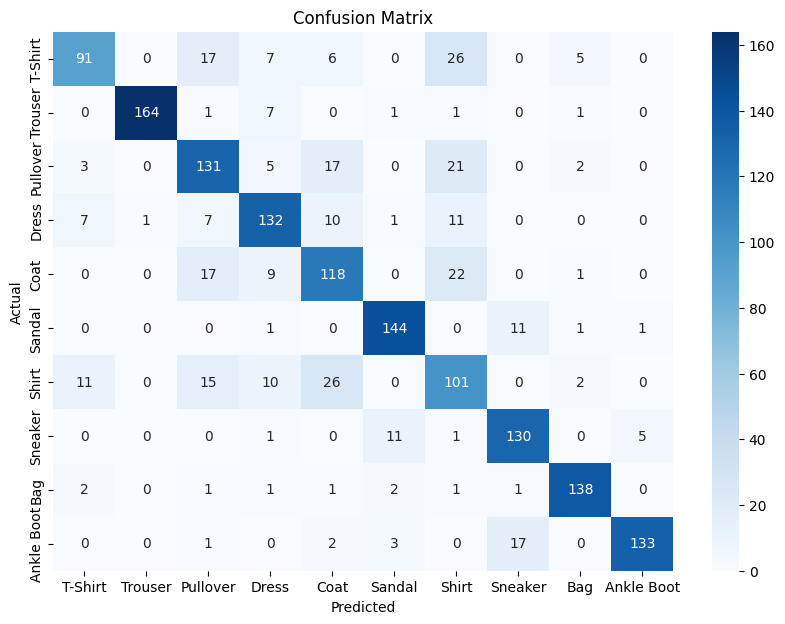

In [58]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.values(), yticklabels=LABELS.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 13 Prediction

Generating the CSV to submit to DataHack.

In [59]:
submission_dataset = ApparelDataset.load(csv_path='data/test.csv', images_path='data/test', preprocessing=preprocessing)
submission_loader = DataLoader(submission_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)
print("Submission dataset:", submission_dataset, len(submission_dataset), "records.")

Submission dataset: <apparel.ApparelDataset object at 0x1637503a0> 10000 records.


In [60]:
def predict(model: ApparelsModel, loader: DataLoader) -> np.array:
    y_hat = []
    model.eval() # Sets the model in evaluation model, which disables Dropout.
    start_time = time.time()
    with torch.no_grad():
        for batch_number, inputs in enumerate(loader):
            print(datetime.now(), "Prediction - Batch:", batch_number, "of", len(loader), "ETA:", get_eta(start_time, batch_number, len(loader)))
            inputs = inputs.to(PROCESSOR)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            y_hat.extend(predictions.cpu().numpy())
            if batch_number == STOP_AT_BATCH: break
    return y_hat

In [61]:
predictions = predict(model, submission_loader)

if isinstance(STOP_AT_BATCH, int) and STOP_AT_BATCH >= 0:
    submission_dataset.df = submission_dataset.df.iloc[:len(predictions)].copy()
assert len(predictions) == len(submission_dataset)

submission_dataset.df['label'] = predict(model, submission_loader)
submission_dataset.df.to_csv(PREDICTIONS_PATH, index=False)

2024-06-23 22:51:35.163537 Prediction - Batch: 0 of 625 ETA: 2024-06-23 23:33:36.183137
2024-06-23 22:51:35.654798 Prediction - Batch: 1 of 625 ETA: 2024-06-23 23:38:39.097483
2024-06-23 22:51:36.072564 Prediction - Batch: 2 of 625 ETA: 2024-06-23 23:17:15.665758
2024-06-23 22:51:36.536251 Prediction - Batch: 3 of 625 ETA: 2024-06-23 23:10:17.423370
2024-06-23 22:51:37.004978 Prediction - Batch: 4 of 625 ETA: 2024-06-23 23:06:49.088509
2024-06-23 22:51:37.505802 Prediction - Batch: 5 of 625 ETA: 2024-06-23 23:04:48.099819
2024-06-23 22:51:37.963219 Prediction - Batch: 6 of 625 ETA: 2024-06-23 23:03:22.918315
2024-06-23 22:51:38.393449 Prediction - Batch: 7 of 625 ETA: 2024-06-23 23:02:19.647751
2024-06-23 22:51:38.819709 Prediction - Batch: 8 of 625 ETA: 2024-06-23 23:01:31.884604
2024-06-23 22:51:39.277381 Prediction - Batch: 9 of 625 ETA: 2024-06-23 23:00:56.916886
2024-06-23 22:51:39.706305 Prediction - Batch: 10 of 625 ETA: 2024-06-23 23:00:27.146020
2024-06-23 22:51:40.174207 Pred

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 22:52:44.863440 Prediction - Batch: 0 of 101 ETA: 2024-06-23 23:00:22.365936
2024-06-23 22:52:45.488237 Prediction - Batch: 1 of 101 ETA: 2024-06-23 23:01:20.929886
2024-06-23 22:52:45.985629 Prediction - Batch: 2 of 101 ETA: 2024-06-23 22:57:25.749369
2024-06-23 22:52:46.506163 Prediction - Batch: 3 of 101 ETA: 2024-06-23 22:56:08.135020
2024-06-23 22:52:46.985073 Prediction - Batch: 4 of 101 ETA: 2024-06-23 22:55:28.277212
2024-06-23 22:52:47.418142 Prediction - Batch: 5 of 101 ETA: 2024-06-23 22:55:03.436495
2024-06-23 22:52:47.829924 Prediction - Batch: 6 of 101 ETA: 2024-06-23 22:54:46.517776
2024-06-23 22:52:48.255547 Prediction - Batch: 7 of 101 ETA: 2024-06-23 22:54:34.632577
2024-06-23 22:52:48.664134 Prediction - Batch: 8 of 101 ETA: 2024-06-23 22:54:25.503663
2024-06-23 22:52:49.073405 Prediction - Batch: 9 of 101 ETA: 2024-06-23 22:54:18.411075
2024-06-23 22:52:49.485338 Prediction - Batch: 10 of 101 ETA: 2024-06-23 22:54:12.763866
2024-06-23 22:52:49.900412 Pred

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

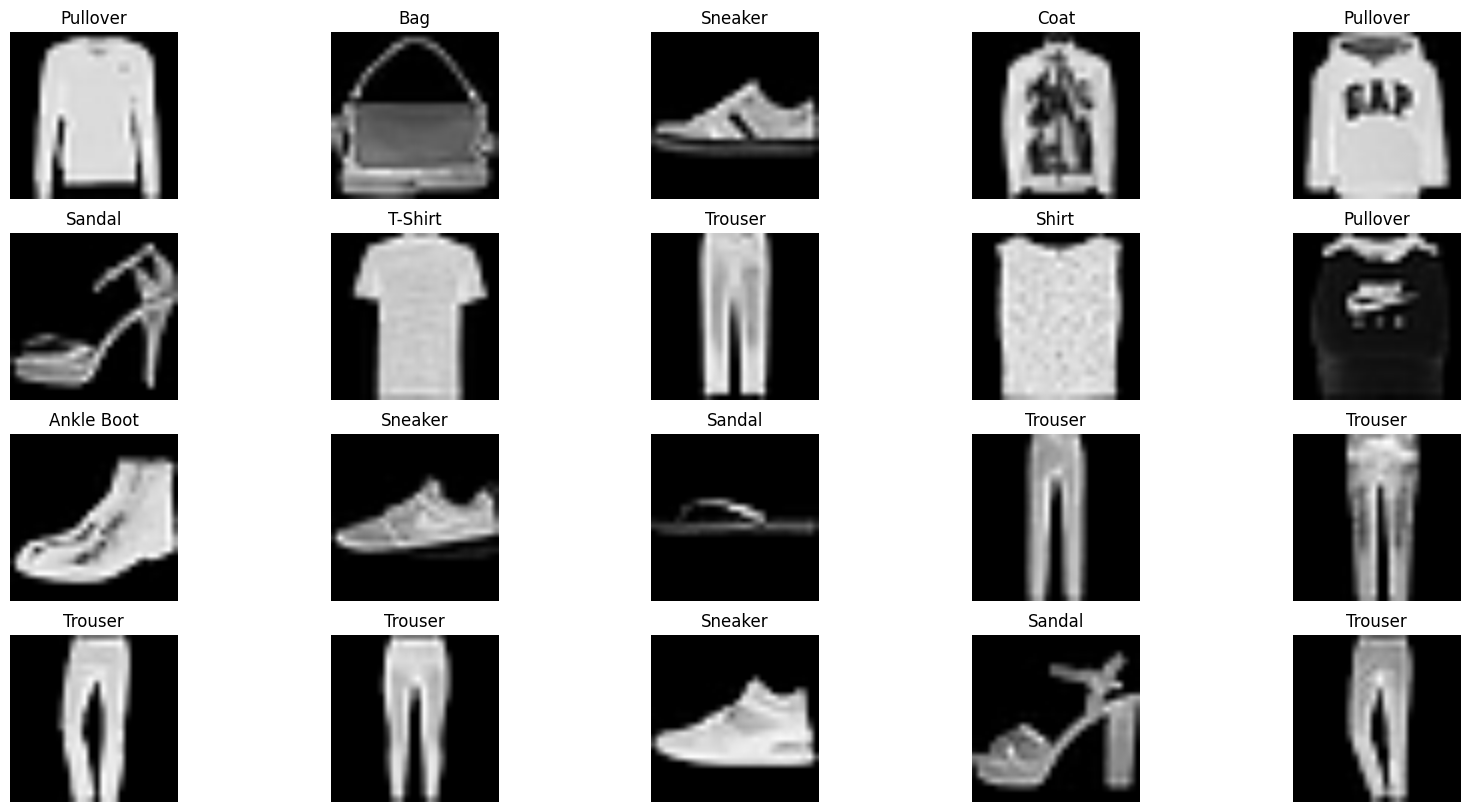

In [62]:
sample_dataset(submission_dataset)